In [1]:
import os
import random
import soundfile as sf
from tqdm import tqdm
import numpy as np
import csv
from pathlib import Path
import scipy.signal

In [2]:
nearEnd_dir = "D:/nearend_speech/rename/audio_files"
echoSignal_dir = "D:/AEC-Challenge/datasets/synthetic/echo_signal"
farEnd_dir = "D:/AEC-Challenge/datasets/synthetic/farend_speech"
output_dir = "D:/AEC-Challenge/datasets/material"
#noise_dir = "D:/Downloads/archive/ESC-50-master/audio"
os.makedirs(output_dir, exist_ok=True)
#SNR_range = [10,40]
#SER_range = [-5,10] 

In [3]:
def resample_signal(audio, orig_sr, target_sr):
    """Đổi tần số lấy mẫu của âm thanh."""
    if orig_sr == target_sr:
        return audio
    num_samples = int(len(audio) * float(target_sr) / orig_sr)
    return scipy.signal.resample(audio, num_samples)

def get_farend_path_from_echo(echo_filename, farend_dir):
    """
    Logic tìm file Far-end từ tên file Echo.
    Input: echo_fileid_123.wav
    Output: path/to/farend_speech_fileid_123.wav
    """
    try:
        base_name = os.path.splitext(echo_filename)[0]
        file_id = base_name.split('_')[-1] 

        farend_name = f"farend_speech_fileid_{file_id}.wav"
        farend_path = os.path.join(farend_dir, farend_name)
        

        if os.path.exists(farend_path):
            return farend_path, farend_name
        else:
            return None, None
    except Exception:
        return None, None

In [ ]:
def caculate_rms(audio):
    if len(audio)==0:
        return 0
    return np.sqrt(np.mean(audio**2))

def relength_echo_signal(source_audio, target_len):
    target_len = int(target_len)
    currentLength = len(source_audio)

    if currentLength < target_len:
        diff = target_len - currentLength
        if len(source_audio.shape) == 2:
            # Stereo:
            channels = source_audio.shape[1]
            padding = np.zeros((diff, channels))
        else:
            # Mono
            padding = np.zeros(diff)
        return np.concatenate((source_audio, padding))
    elif currentLength > target_len:
        return source_audio[:target_len]
    else:
        return source_audio

"""
def apply_distortion(audio_sig):
    if random.random()>0.7:
        return audio_sig,"linear"
    distortion_type = 'clipping'
    distorted_sig = audio_sig.copy()

    if distortion_type == 'clipping':
        max_val = np.max(np.abs(audio_sig))
        if max_val > 0:
            threshold = random.uniform(0.8,0.95) * max_val
            distorted_sig = np.clip(audio_sig, -threshold, threshold)
    return distorted_sig, distortion_type
"""
def calculate_gain(clean_rms, noise_rms, target_snr):
    if noise_rms == 0 or clean_rms == 0:
        return 1.0
    target_rms_noise = clean_rms / (10 ** (target_snr / 20))
    return target_rms_noise / noise_rms

def mix_data(nearEnd_dir, echoSignal_dir, output_dir):

    micSignal_dir = os.path.join(output_dir, "mic")
    refSignal_dir = os.path.join(output_dir, "ref")

    Path(micSignal_dir).mkdir(parents=True, exist_ok=True)
    Path(refSignal_dir).mkdir(parents=True, exist_ok=True)
    metadata_path = os.path.join(output_dir, "dataset_config.csv")
    validFileExtensions = ('.wav', '.mp3')
    nearEndFiles = sorted([f for f in os.listdir(nearEnd_dir) if f.lower().endswith(validFileExtensions)])
    echoSignalFiles = [f for f in os.listdir(echoSignal_dir) if f.lower().endswith(validFileExtensions)]
    
    
    #noiseSignalfiles = [f for f in os.listdir(noise_dir) if f.lower().endswith(validFileExtensions)]
    
    print(f"Processng {len(nearEndFiles)} files...")

    #metadata.csv
    with open(metadata_path, mode='w', newline='', encoding='utf-8') as csv_file:
        max_retries = 100 
        for ne_filename in tqdm(nearEndFiles, desc="Processing"):
            try:
                # --- A. PREPARE COMMON SIGNALS ---
                
                # 1. Load Near-end
                ne_path = os.path.join(nearEnd_dir, ne_filename)
                nearEnd_sig, sr = sf.read(ne_path)
                target_len = len(nearEnd_sig)
                rms_ne = caculate_rms(nearEnd_sig)

                # --- SỬA LỖI Ở ĐÂY: VÒNG LẶP CHỌN ECHO (RETRY) ---
                echo_filename = None
                farend_path = None
                farend_filename = None
                
                # Thử chọn echo tối đa 10 lần. Nếu quá 10 lần vẫn lỗi thì mới bỏ qua file near-end này.
                
                found_valid_echo = False
                
                for _ in range(max_retries):
                    temp_echo = random.choice(echoSignalFiles)
                    temp_farend_path, temp_farend_name = get_farend_path_from_echo(temp_echo, farEnd_dir)
                    
                    if temp_farend_path: # Nếu tìm thấy Far-end
                        # Kiểm tra thêm: Echo có bị im lặng không?
                        # (Để check kỹ thì phải load file, nhưng load nhiều sẽ chậm. 
                        # Tạm thời chỉ check path, phần check RMS để sau khi load)
                        echo_filename = temp_echo
                        farend_path = temp_farend_path
                        farend_filename = temp_farend_name
                        found_valid_echo = True
                        break # Tìm được rồi thì thoát vòng lặp retry
                
                if not found_valid_echo:
                    print(f" SKIP: Đã thử {max_retries} lần nhưng không tìm thấy cặp Echo-Farend hợp lệ cho {ne_filename}")
                    continue

                echo_path = os.path.join(echoSignal_dir, echo_filename)
                echo_sig, sr_echo = sf.read(echo_path)
                farend_sig, sr_fe = sf.read(farend_path)

                if sr != sr_echo: echo_sig = resample_signal(echo_sig, sr_echo, sr)
                if sr != sr_fe: farend_sig = resample_signal(farend_sig, sr_fe, sr)

                target_len = len(nearEnd_sig)
                echo_aligned = relength_echo_signal(echo_sig, target_len)
                farend_aligned = relength_echo_signal(farend_sig, target_len)

                target_ser_db = random.uniform(-5,10)
                rms_ne = caculate_rms(nearEnd_sig)
                rms_echo = caculate_rms(echo_aligned)

                if rms_echo == 0 or rms_ne == 0:
                    echo_scaled = echo_aligned
                else:
                    target_rms_echo = rms_ne / (10**(target_ser_db/20))
                    gain = target_rms_echo / rms_echo
                    echo_scaled = echo_aligned * gain

                #noise optional
                #noise_add = np.zeros_like(nearEnd_sig)
                #noise_filename = "None"
                target_snr = 0 
                """
                if random.random()>0.5 and len(noiseSignalfiles)>0:
                    noise_filename = random.choice(noiseSignalfiles)
                    noise_path = os.path.join(noise_dir, noise_filename)
                    noise_sig, sr_noise = sf.read(noise_path)
                    
                    if sr != sr_noise:
                        noise_sig = resample_signal(noise_sig, sr_noise, sr)
                    noise_aligned = relength_echo_signal(noise_sig, target_len)  
                    rms_noise = caculate_rms(noise_aligned)                            
                    target_snr = random.uniform(10,40)
                    gain_noise = calculate_gain(rms_ne, rms_noise, target_snr)
                    noise_add = noise_aligned * gain_noise
                """
                #echo_distortion, dist_type = apply_distortion(echo_scaled)
                mic_signal = nearEnd_sig + echo_scaled
                #fix 
                ref_signal_final = farend_aligned

                max_amp = np.max(np.abs(mic_signal))
                if max_amp > 1.0:
                    mic_signal /= max_amp
                    ref_signal_final /= max_amp
                
                out_mic_path = os.path.join(micSignal_dir, ne_filename)
                out_ref_path = os.path.join(refSignal_dir, ne_filename)

                sf.write(out_mic_path, mic_signal, sr)
                sf.write(out_ref_path, ref_signal_final, sr)

                

                
                # Ghi vào CSV
                
            except Exception as e:
                print(f"Error processing {ne_filename}: {e}")       

In [5]:
"""
"""
mix_data(nearEnd_dir,echoSignal_dir,output_dir)

Processng 7991 files...


Processing: 100%|██████████| 7991/7991 [20:46<00:00,  6.41it/s]


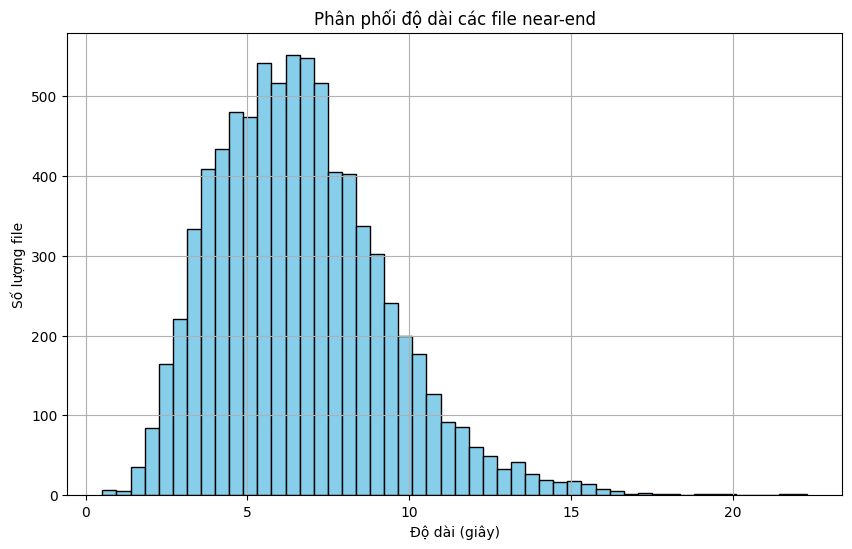

In [6]:
# Thống kê độ dài các file near-end và vẽ biểu đồ phân phối
import matplotlib.pyplot as plt
lengths = []
for ne_filename in os.listdir(nearEnd_dir):
    if ne_filename.lower().endswith(('.wav', '.mp3')):
        ne_path = os.path.join(nearEnd_dir, ne_filename)
        try:
            audio, sr = sf.read(ne_path)
            lengths.append(len(audio) / sr)  # Đơn vị: giây
        except Exception as e:
            print(f"Lỗi đọc {ne_filename}: {e}")
plt.figure(figsize=(10,6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Độ dài (giây)')
plt.ylabel('Số lượng file')
plt.title('Phân phối độ dài các file near-end')
plt.grid(True)
plt.show()